In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pydrake.solvers.mathematicalprogram as mp

In [3]:
import numpy as np
import mpc_tools as mpc
import mpc_tools.mpcqp as mqp

In [16]:
m = 1.
l = 1.
g = 10.
A = np.array([
    [0., 1.],
    [g/l, 0.]
])
B = np.array([
    [0.],
    [1/(m*l**2.)]
])
t_s = .1
sys = mpc.DTLinearSystem.from_continuous(t_s, A, B)
N = 5
Q = np.eye(A.shape[0])/100.
R = np.eye(B.shape[1])
x_max = np.array([[np.pi/6.], [np.pi/20./(N*t_s)]])
x_min = -x_max
u_max = np.array([[m*g*l*np.pi/8.]])
u_min = -u_max

In [17]:
factory = mqp.MPCQPFactory(sys, N, Q, R)
factory.add_state_bound(x_max, x_min)
factory.add_input_bound(u_max, u_min)

mpc_qp = factory.assemble()

In [18]:
prog = mp.MathematicalProgram()
x = prog.NewContinuousVariables(2, N, "x")
u = prog.NewContinuousVariables(1, N, "u")
for j in range(N):
    x_next = sys.A.dot(x[:, j]) + sys.B.dot(u[:, j])
    for i in range(x.shape[0]):
        prog.AddLinearConstraint(x_next[i] <= x_max[i])
        prog.AddLinearConstraint(x_next[i] >= x_min[i])
        
    for i in range(u.shape[0]):
        prog.AddLinearConstraint(u[i, j] <= u_max[i])
        prog.AddLinearConstraint(u[i, j] >= u_min[i])
    
    if j < N - 1:
        for i in range(x.shape[0]):
            prog.AddLinearConstraint(x[i, j + 1] == x_next[i])

    prog.AddQuadraticCost(x_next.dot(Q).dot(x_next))
    prog.AddQuadraticCost(u[:, j].dot(R).dot(u[:, j]))
sym_qp = mqp.CanonicalMPCQP.from_mathematicalprogram(prog, u, x)

In [19]:
controller = mpc.MPCController(sym_qp, u.shape[0])

In [20]:
controller.compute_explicit_solution()

Computing critical region for the active set []
Computing critical region for the active set [2]
Computing critical region for the active set [3]
Computing critical region for the active set [12]
Computing critical region for the active set [13]
Computing critical region for the active set [2, 12]
Computing critical region for the active set [2, 13]
LICQ does not hold for the active set [2, 15]
    unfeasible critical region detected
Computing critical region for the active set [3, 12]
Computing critical region for the active set [3, 13]
LICQ does not hold for the active set [3, 14]
    unfeasible critical region detected
Computing critical region for the active set [12, 15]
Computing critical region for the active set [13, 14]
LICQ does not hold for the active set [2, 12, 15]
    unfeasible critical region detected
LICQ does not hold for the active set [2, 13, 14]
    corrected active set [13, 14]
Computing critical region for the active set [13, 14]
LICQ does not hold for the active 

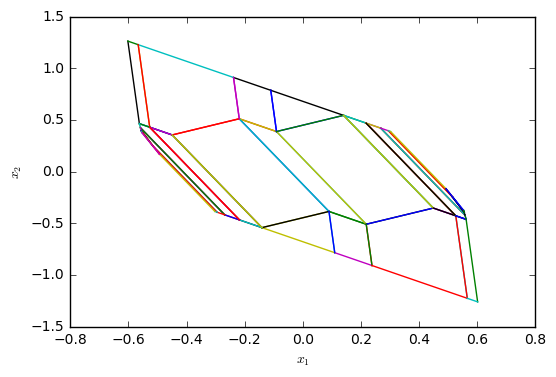

In [21]:
for cr in controller.critical_regions:
    cr.polytope.plot()